In [46]:
import os
def change_to_code_dir():
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == "p2ch15":
        parent_dir = os.path.dirname(current_dir)
        os.chdir(parent_dir)    
change_to_code_dir()

In [47]:
import torch
from PIL import Image
from p2ch15.utils import FineTuningDataset, plot_tensor_histogram, plot_mask, plot_image_and_masks
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
id2label = {"0": "background", "1": "nodule"}
label2id = {v: k for k, v in id2label.items()}

fine_tuning_dir = "data-unversioned/part2/fine-tuning/dataset"

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)
# state_dict = torch.load(f"{fine_tuning_dir}/../segformer_3_9_2025_epoch_15.pth")
state_dict = torch.load("p2ch15/segformer_epoch_20.pt")
model.load_state_dict(state_dict)
model.to(device)
print("Model loaded")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


C:\Users\howardhuang\AppData\Local\Temp\ipykernel_12172\1412832853.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("p2ch15/segformer_epoch_20.pt

In [53]:
val_data = FineTuningDataset(split="val")

In [54]:
image_processor = SegformerImageProcessor()

In [72]:
data = [val_data[8], val_data[10], val_data[20]]
def inference(model, image_path, mask_image_path, show_plot=False):
    model.eval()
    image = Image.open(image_path)
    mask_image = Image.open(mask_image_path)
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[(512, 512)])[0]
    if show_plot:
        plot_image_and_masks(image, mask_image, predicted_segmentation_map.cpu().numpy())
    return predicted_segmentation_map

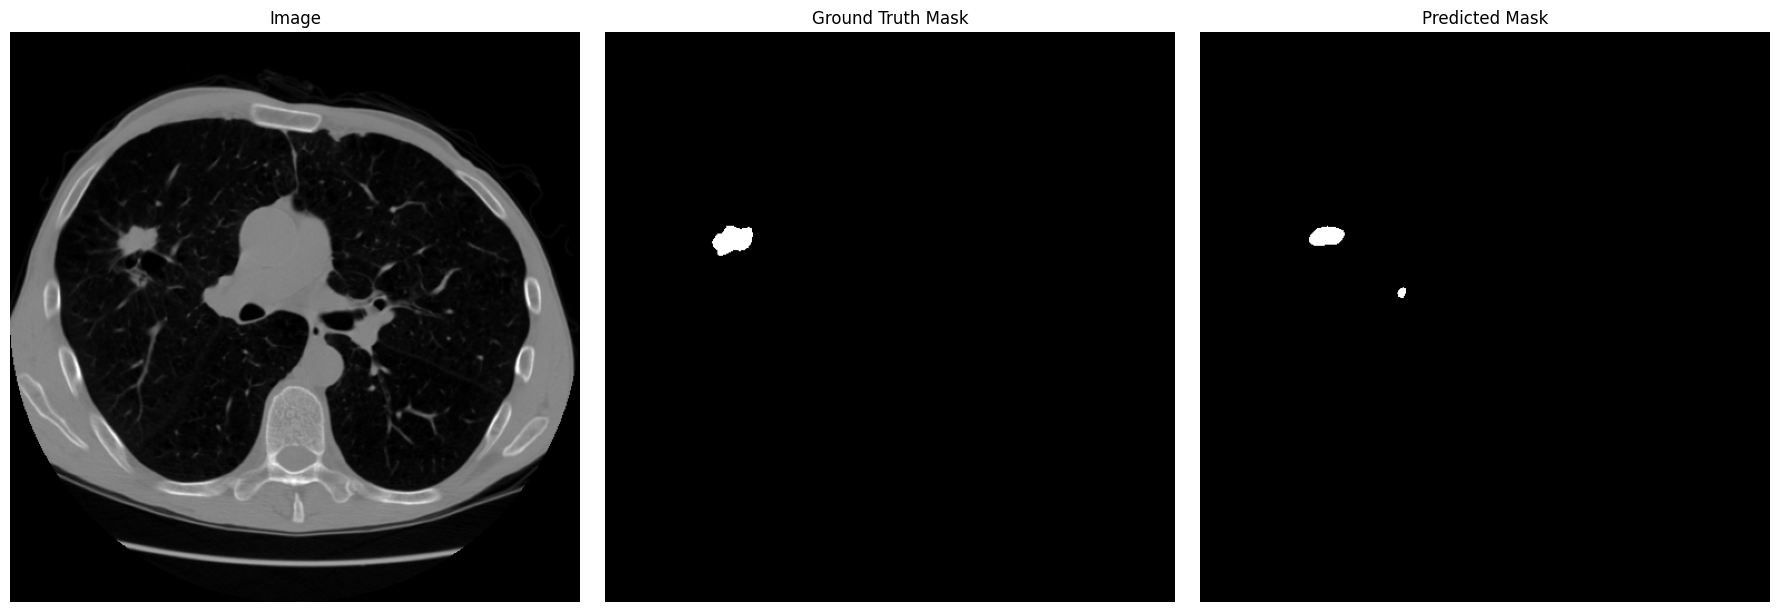

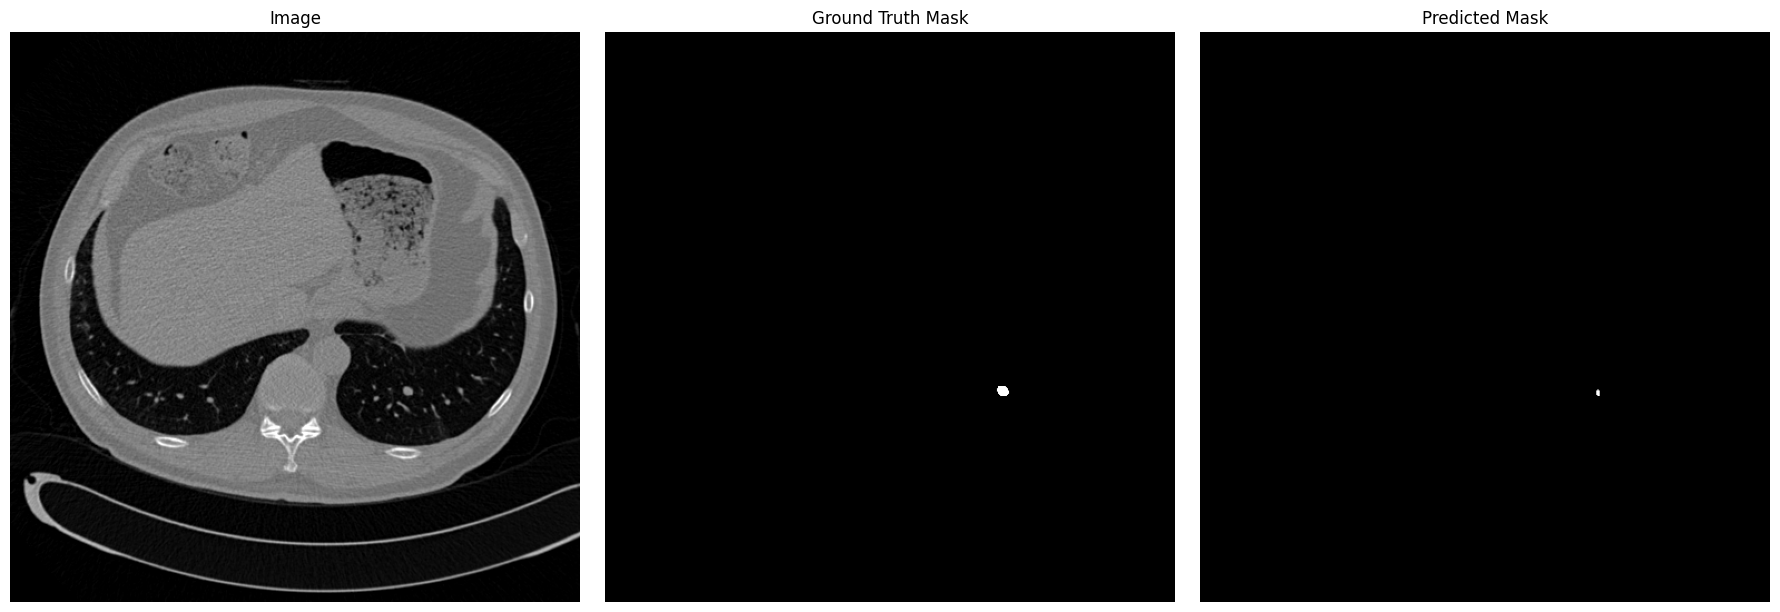

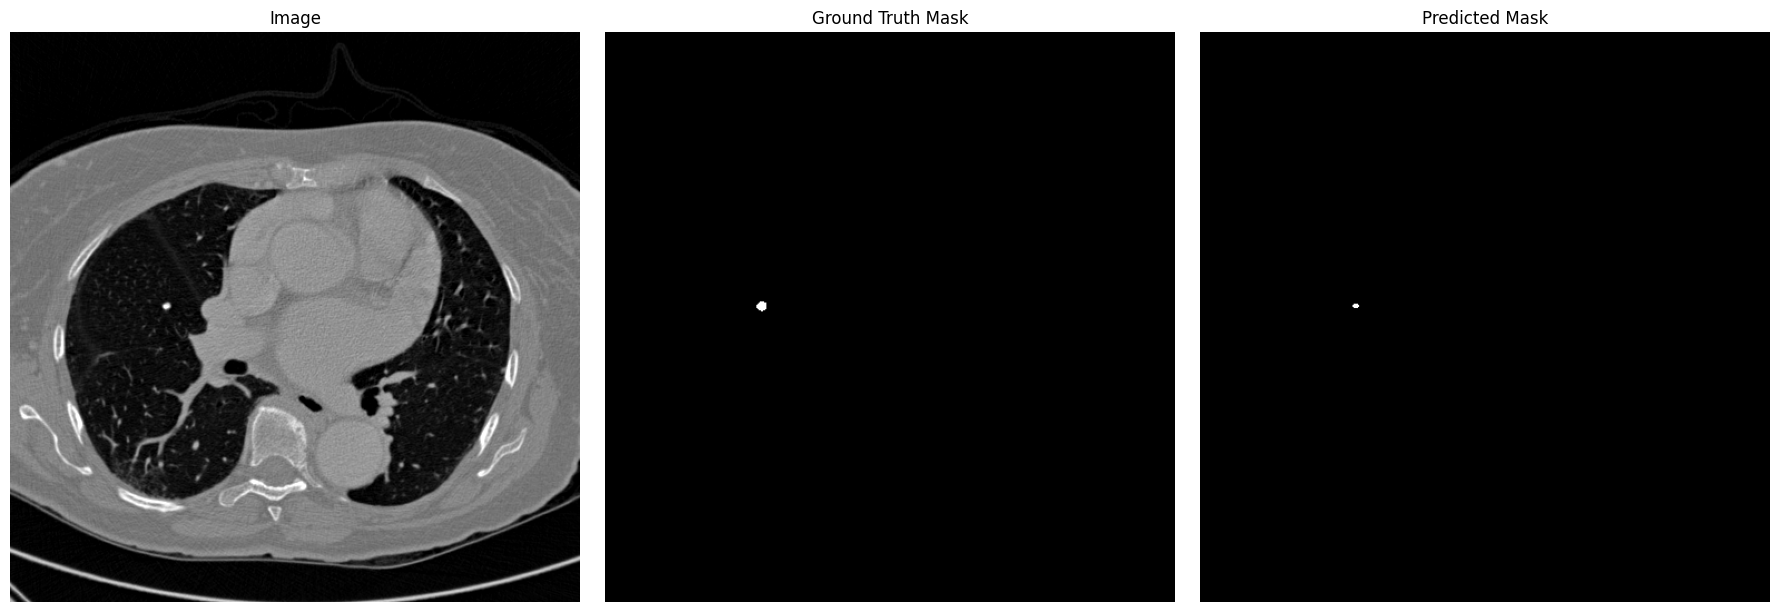

In [71]:
for data_point in data:
    output_mask = inference(model, data_point["ct_image_path"], data_point["mask_image_path"], show_plot=True)

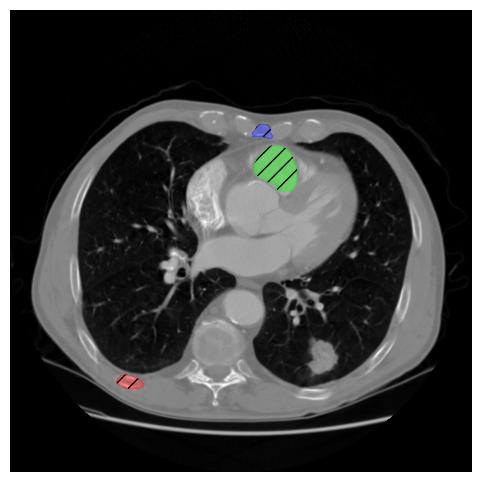

In [52]:
plot_original_image_with_masks(image, [mask["segmentation"] for mask in masks if mask["area"] < 2000])